# Example of one synthetic experiment

In [1]:
import sys
import os
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from simulation_helpers import run_simul

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.extend([
    os.path.join(parent_dir, "pycvxcluster"),
    parent_dir 
])

import pycvxcluster.pycvxcluster
from GpLSI import generate_topic_model as gen_model
from GpLSI.utils import *
from GpLSI import gplsi
import utils.spatial_lda.model


from collections import defaultdict

/opt/anaconda3/envs/rpyenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We start by first generating one synthetic dataset. Each dot represents a document and each color represents a topic. We first generate $n$ points (documents) over a unit square $[0,1]^2$. Then, we divide the unit square into *n_clusters* equally spaced grids and get the center for each grid. We apply k-means algorithm to the points with these as initial centers. This will divide the unit square into 30 different clusters. Next, we randomly assign these clusters to $3$ different topics. In the end, within the same topic, we will observe some clusters of documents that are not necessarily next to each other.

Topic mixtures (row's of $W$) are generated so that they match the dominant topic for each document and entries of $A$ are generated randomly from a uniform distribution.

Below, for each document $i$, the topic with the highest topic mixture weight $W_{ik}$ is plotted.

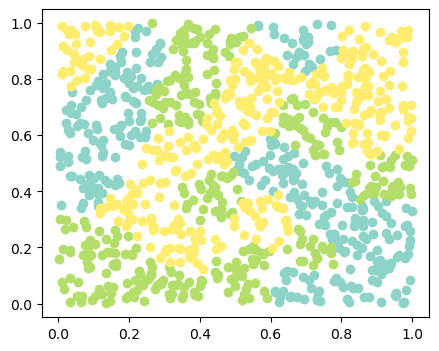

In [2]:
N = 100  # doc length
n = 1000  # number of nodes
p = 30  # vocab size
K = 3  # number of topics
r = 0.05  # heterogeneity parameter
m = 5  # number of neighbors to be considered in weights
phi = 0.1  # weight parameter
n_clusters = 30 # number of patches
np.random.seed(500)
coords_df, W, A, X = gen_model.generate_data(N, n, p, K, r, n_clusters)
weights, edge_df = gen_model.generate_weights_edge(coords_df, m, phi)
plt.figure(figsize=(5,4))
gen_model.plot_scatter(coords_df)

We visualize the spatial graph of the documents and the corresponding minimum spanning tree which will later be used for cross-validation to optimize the graph regularization parameter.

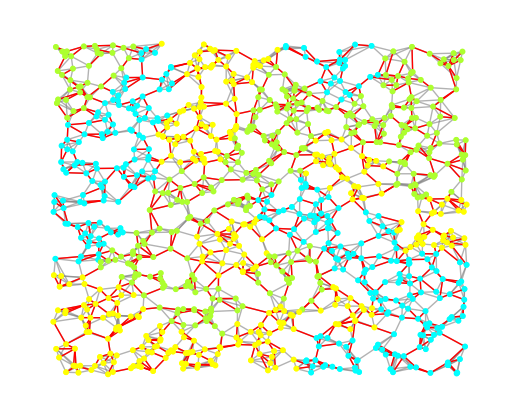

In [3]:
G, mst = get_mst(edge_df)
srn, fold1, fold2 = get_folds(mst)
folds = {0: fold1, 1: fold2}
colors = gen_model.get_colors(coords_df)
colors = [colors[node] for node in G.nodes]

plt.figure(figsize=(5,4))
# Plot the random graph
pos_dict = {node: (coords_df["x"][node], coords_df["y"][node]) for node in G.nodes}
nx.set_node_attributes(G, pos_dict, "pos")
pos = nx.get_node_attributes(G, "pos")
nx.draw(G, pos, with_labels=False, node_size=10, node_color=colors, edge_color="gray", alpha=0.6)

# Plot the minimum spanning tree in red
nx.draw(mst, pos, with_labels=False, node_size=10, node_color=colors, edge_color="r", alpha=1)

plt.show()

With the observed frequency matrix $X$, we now fit five different methods : **GpLSI**, pLSI, TopicScore, LDA, and SLDA and compare the estimated $W$'s with the ground truth $W$. 

In [4]:
results = run_simul(nsim=1, N=N, n=n, K=K, p=p, start_seed=500)

Running trial 0...
Running pLSI...
Running SPOC...
Running graph aligned pLSI...
Initializing...


/Users/jeong-yeojin/Dropbox/내 Mac (정여진의 MacBook Pro)/Desktop/GpLSI/pycvxcluster/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Dropbox/내 Mac (정여진의 MacBook Pro)/Desktop/GpLSI/pycvxcluster/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Dropbox/내 Mac (정여진의 MacBook Pro)/Desktop/GpLSI/pycvxcluster/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Dropbox/내 Mac (정여진의 MacBook Pro)/Desktop/GpLSI/pycvxcluster/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Dropbox/

Optimal lambda is 0.013552527156068805...


/Users/jeong-yeojin/Dropbox/내 Mac (정여진의 MacBook Pro)/Desktop/GpLSI/pycvxcluster/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Dropbox/내 Mac (정여진의 MacBook Pro)/Desktop/GpLSI/pycvxcluster/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/jeong-yeojin/Dropbox/내 Mac (정여진의 MacBook Pro)/Desktop/GpLSI/pycvxcluster/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Dropbox/내 Mac (정여진의 MacBook Pro)/Desktop/GpLSI/pycvxcluster/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/jeong-yeojin/Dropbox/

Optimal lambda is 0.013552527156068805...
Graph-aligned SVD ran for 2 steps.
Running SPOC...
CV Lambda is 0.013552527156068805
Running LDA...
Running SLDA...


We can observe that GpLSI achieves the smallest errors of both $W$ and $A$.

In [5]:
pd.DataFrame(results.iloc[0,:37])

,0
trial,0.000000
jump,0.764518
N,100.000000
n,1000.000000
p,30.000000
K,3.000000
plsi_err,7.345061
plsi_l1_err,317.535569
A_plsi_err,0.069582
A_plsi_l1_err,0.501787


We visulaize the estimated $W$ for each method and visually compare with the ground truth. Here, we only plot the weight for the first topic. Clearly, GpLSI's estimate is closest to the ground truth.

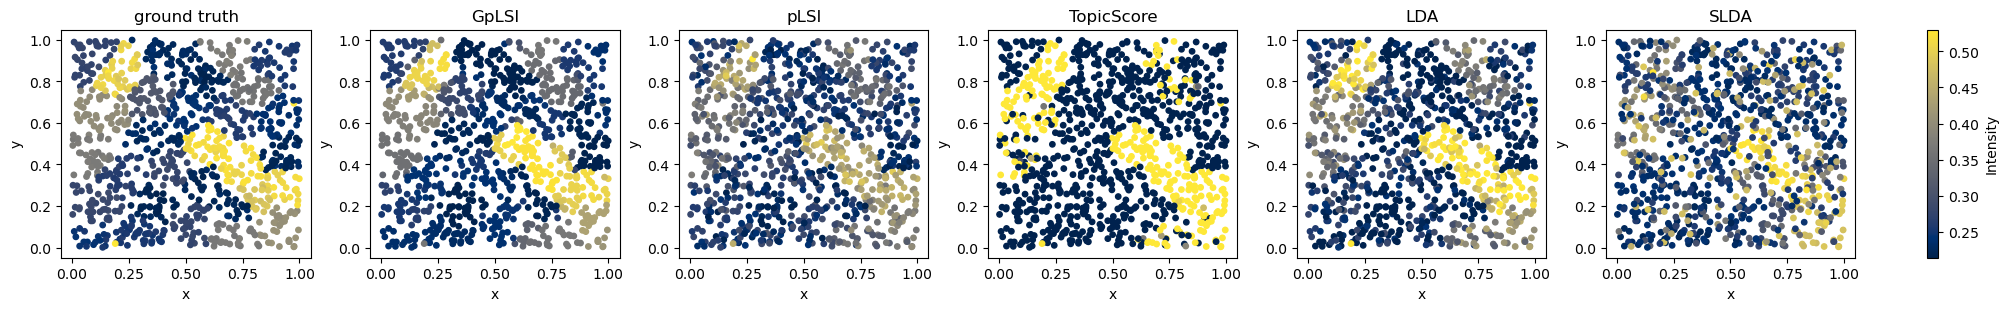

In [6]:
names = ['ground truth', 'GpLSI', 'pLSI', 'TopicScore', 'LDA', 'SLDA']
with open('sim_models/W_hats.pkl', 'rb') as f:
    W_hats = pkl.load(f)

coords_df = W_hats[-1]
fig, axs = plt.subplots(1, 6, figsize=(20, 3), constrained_layout=True)
for i in range(len(W_hats)-1):
    scatter = axs[i].scatter(
        coords_df["x"], coords_df["y"], c=W_hats[i][:,0], cmap="cividis", s=15
    )
    axs[i].set_title(names[i])
    axs[i].set_xlabel("x")
    axs[i].set_ylabel("y")
cbar = fig.colorbar(scatter, ax=axs, orientation="vertical", fraction=0.02, pad=0.04)
cbar.set_label("Intensity")
plt.show()

We now visualize cross validation errors for GpLSI. We can see that the cross validation curves across 5 folds have nice convex shapes.

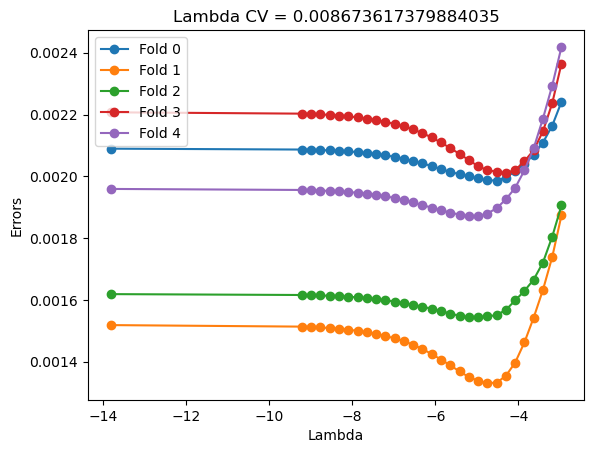

In [7]:
with open('sim_models/simul_N=1000_n=1000_K=3_p=30_trial=0.pkl', 'rb') as f:
    model = pkl.load(f)
model_gplsi = model['gplsi']

lamb_start = model_gplsi[0].lamb_start
step_size = model_gplsi[0].step_size
grid_len = model_gplsi[0].grid_len
lambd_grid = (lamb_start * np.power(step_size, np.arange(grid_len))).tolist()
lambd_grid.insert(0, 1e-06)

plot_fold_cv(lambd_grid, model_gplsi[0].lambd_errs, model_gplsi[0].lambd, N)